In [174]:
import operator
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import sys
import gc

import optuna
import logging
import pickle

from collections.abc import Callable

from pso_utils import *
from landscapes_utils import *

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100
gp_run_check = False # when true we can perform the run

In [3]:
def save_log(log, path='logs/log_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(log, lb_file)

def load_log(path='logs/log_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

def save_hof(hof, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(hof, lb_file)

def load_hof(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)
    
def save_pop(pop, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(pop, lb_file)

def load_pop(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

In [4]:
def get_ones(_):
    return np.ones((SWARM_SIZE, 2))

def get_pi(_):
    return get_ones(None) * np.pi

In [5]:
def func_dec(func):
    def new_func(swarm, velocity, global_best, personal_best, center_mass, dispersion):
        value = func(swarm, velocity, global_best, personal_best, center_mass, dispersion)
        if not isinstance(value, np.ndarray):
            return np.zeros((SWARM_SIZE, 2))
        else:
            try:
                value.shape[1] == 2
                return value
            except Exception:
                value = value.reshape(-1, 1)
                value = np.hstack((value, value))
                return value
    return new_func

In [6]:
def gen_rand(_):
    return np.random.uniform(np.zeros(2), np.ones(2), size=(SWARM_SIZE, 2))

In [172]:
def GP_RUN(name=None, mut_type='uni'):
    pset = gp.PrimitiveSet("MAIN", 6)
    # basic
    pset.addPrimitive(np.add, 2)
    pset.addPrimitive(np.negative, 1)
    pset.addPrimitive(np.subtract, 2)
    pset.addPrimitive(np.multiply, 2)
    pset.addPrimitive(gen_rand, 1)


    # PRIMITIVES
    pset.addTerminal(np.pi)
    pset.addTerminal(1)
    # ephemeral constants
    pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))


    # variables
    pset.renameArguments(ARG0="swarm")
    pset.renameArguments(ARG1="vel")
    pset.renameArguments(ARG2='gbest')
    pset.renameArguments(ARG3='pbest')
    pset.renameArguments(ARG4='center')
    pset.renameArguments(ARG5='dispersion')
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10) # 3<5
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    def GPFitness(individual):
        problems = generate_problems(NUM_PROBLEMS)
        func = toolbox.compile(expr=individual)
        func = func_dec(func)
        vel_update = func
        S = SwarmGP(SWARM_SIZE, vel_update=vel_update)
        results = PSOResults(S, problems, NUM_ITERATIONS)
        value = float(np.median(results) + np.std(results))
        print(f'value = {value} -> ind = {individual}')
        return value,


    toolbox.register("evaluate", GPFitness)
    toolbox.register("select", tools.selTournament, tournsize=3) # 1:1 replacement selection
    toolbox.register("mate", gp.cxOnePoint) # subtree crossover


    # mutations
    if mut_type == 'uni':
        toolbox.register("expr_mut", gp.genFull, min_=0, max_=6)
        toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    elif mut_type == 'shrink':
        toolbox.register("mutate", gp.mutShrink)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))

    def gp_run():
        random.seed(318)

        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(5)

        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        stats_height = tools.Statistics(lambda ind: ind.height)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size, height=stats_height)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)



        pop, log = algorithms.eaSimple(pop, toolbox, 0.3, 0.2, ngen=20, stats=mstats,
                                    halloffame=hof, verbose=False)
        # doesn't recompute individuals that do not change
        if name is not None:
            save_hof(hof, f'logs/hof_{name}.pkl')
            save_pop(pop, f'logs/pop_{name}.pkl')
            save_log(log, f'logs/log_{name}.pkl')
            
        return pop, log, hof
    return gp_run()

In [173]:
if __gp_run_check:
    pop, log, hof = GP_RUN(name='shrink_mut03')

NameError: name '__gp_run_check' is not defined

# Results

In [9]:
for i in range(len(hof)):
    print(f'height = {hof[0].height} and len = {len(hof[0])} -> {hof[0]}')

NameError: name 'hof' is not defined

In [37]:
# first shrink attempt with len = 3 and len = 6 -> negative(multiply(swarm, subtract(3.141592653589793, 1)))

In [38]:
print(log)

NameError: name 'log' is not defined

# plot

In [162]:
pset = gp.PrimitiveSet("MAIN", 6)
# basic
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.negative, 1)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(gen_rand, 1)

# # random
# pset.addPrimitive(gen_random, 1)

# others
# pset.addPrimitive(np.cos, 1)
# pset.addPrimitive(np.sin, 1)


# PRIMITIVES
pset.addTerminal(np.pi)
pset.addTerminal(1)
# ephemeral constants
pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))


# variables
pset.renameArguments(ARG0="swarm")
pset.renameArguments(ARG1="vel")
pset.renameArguments(ARG2='gbest')
pset.renameArguments(ARG3='pbest')
pset.renameArguments(ARG4='center')
pset.renameArguments(ARG5='dispersion')
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10) # 3<5
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [163]:
hof = load_hof('logs/hof_shrink_mut03.pkl')

In [155]:
for i in range(len(hof)):
    # print(f'height = {hof[0].height} and len = {len(hof[0])} -> {hof[0]}')
    print(clean_rand(str(hof[i])))

multiply(multiply(swarm, gen_rand(0)), multiply(gen_rand(0), negative(gen_rand(0))))
multiply(multiply(subtract(swarm, center), gen_rand(0)), multiply(gen_rand(0), negative(gen_rand(0))))
multiply(multiply(swarm, gen_rand(0)), multiply(gen_rand(0), negative(gen_rand(0))))
multiply(multiply(swarm, gen_rand(0)), multiply(gen_rand(0), negative(gen_rand(0))))
multiply(multiply(subtract(swarm, center), gen_rand(0)), multiply(gen_rand(0), negative(gen_rand(0))))


In [157]:
ind = hof[0]
ind

In [170]:
def string_to_tree(expr, pset):
    """
    Converts a string representation of an expression to a PrimitiveTree.
    """
    return gp.PrimitiveTree.from_string(expr, pset)

# Replace the individual's tree with the new tree
new_tree = string_to_tree(str(ind), pset)
ind[:] = new_tree[:]

TypeError: '>=' not supported between instances of 'NoneType' and 'int'

In [171]:
ind.__dict__

{'fitness': deap.creator.FitnessMin((2.0389929684141883,))}

In [169]:
new_tree

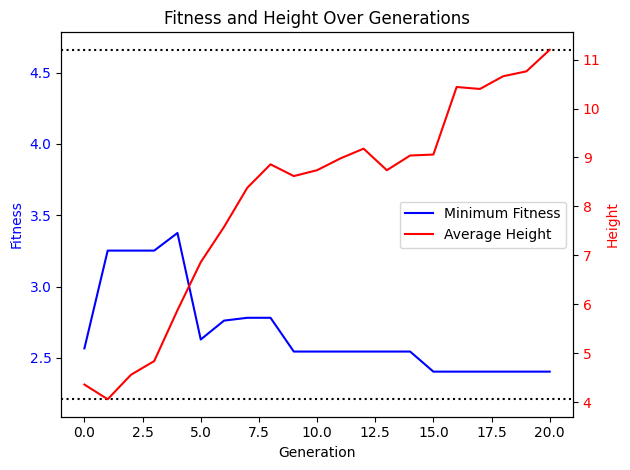

In [32]:
log = log_uni

# Assuming 'log' is your DEAP log object
fig, (ax1, ax2) = plot_log(log)

# Additional customization if needed
ax1.set_title("Fitness and Height Over Generations")

# Save or display the plot
plt.tight_layout()
plt.show()

# Optionally save the figure
fig.savefig("plot_log.png")


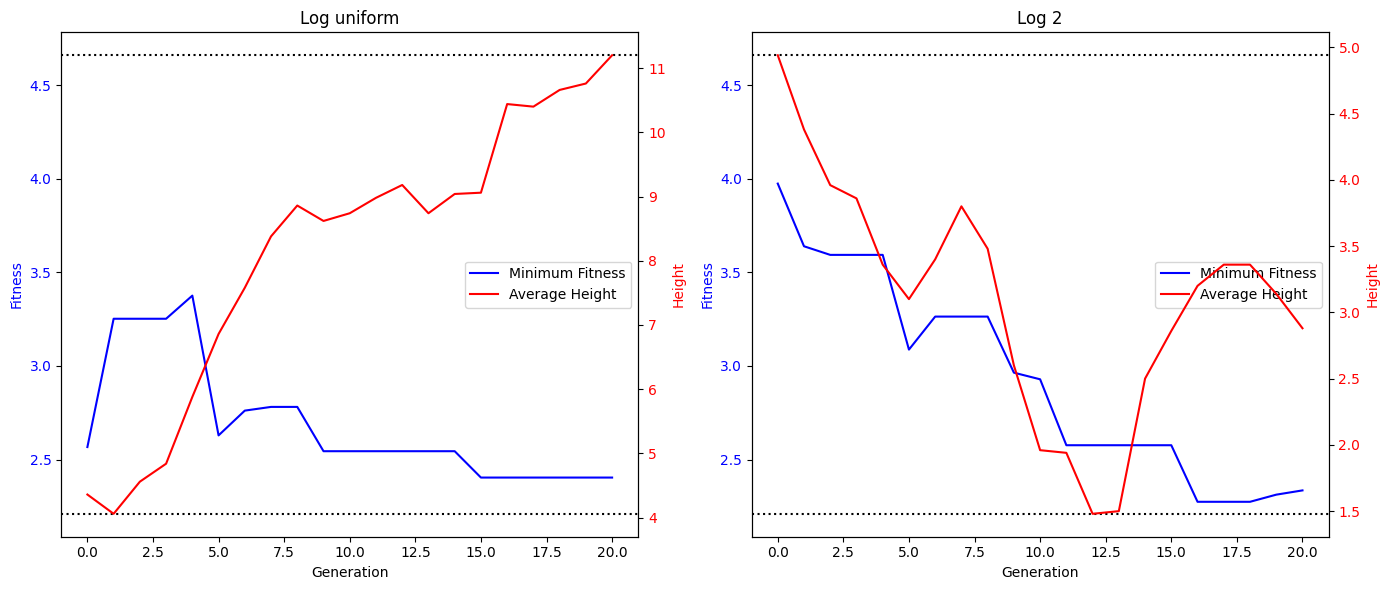

In [33]:
# Create a new figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first log on the first subplot
plot_log(log_uni, ax1=axs[0])
axs[0].set_title("Log uniform")

# Plot the second log on the second subplot
plot_log(log_shrink, ax1=axs[1])
axs[1].set_title("Log 2")

# Adjust layout and display the combined figure
plt.tight_layout()

# clean string

In [140]:
e = 'multiply(gen_rand(gen_rand(gen_rand(negative(negative(multiply(negative(1), negative(vel))))))), gen_rand(9))'

In [150]:
def clean_rand(expr):
    index_open = None
    
    for i in range(len(expr) - 8):
        if expr[i:i + 8] == 'gen_rand' and expr[i:i + 11] != 'gen_rand(0)':
            index_open = i
            break
    if index_open is None:
        return expr
    
    if index_open is not None:

        counter = 1
        for j in range(index_open + 9, len(expr)):
            if expr[j] == '(':
                counter += 1
            elif expr[j] == ')':
                counter -= 1
            
            if counter == 0:
                
                expr = expr[:index_open + 9] + '0' + expr[j:]
                break
        return clean_rand(expr)

    return expr

In [151]:
clean_rand(e)

'multiply(gen_rand(0), gen_rand(0))'

In [139]:
clean_rand(e)
# e[18:]

'multiply(gen_rand(0), gen_rand(9))'